In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tick

endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [2]:
#starter code for queries taken from http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb

# CALLS ON LEGACY PAGECOUNTS API
# traffic data from Dec 2007 through July 2016, format YYYYMMDDHH

# API call for desktop data
desktop_params_pagecounts = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2019090100"
                    }

# API call for mobile data
mobile_params_pagecounts = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2019090100"
                    }

# CALLS ON PAGEVIEWS API
# traffic data from July 2015 through "last month" (August 2019?), format YYYYMMDDHH
#desktop, mobile web, and mobile app

# API call for desktop data
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'
                        }

# API call for mobile web data
mweb_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'
                        }

# API call for mobile app data
mapp_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'
                        }

headers = {
    'User-Agent': 'https://github.com/Chisquareatops',
    'From': 'hertman@uw.edu'
}

In [3]:
# SAVE THE DATA RETURNED BY THE API CALLS INTO JSON SOURCE FILES

# function code taken from http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()    
    return response

# file name convention: apiname_accesstype_firstmonth-lastmonth.json

pagecounts_desktop_call = api_call(endpoint_pagecounts, desktop_params_pagecounts)
pagecounts_desktop = open("pagecounts_desktop-site_200712-201607","w")
json.dump(pagecounts_desktop_call, pagecounts_desktop, indent=4)

pagecounts_mobile_call = api_call(endpoint_pagecounts, mobile_params_pagecounts)
pagecounts_mobile = open("pagecounts_mobile-site_200712-201607","w")
json.dump(pagecounts_mobile_call, pagecounts_mobile, indent=4)

pageviews_desktop_call = api_call(endpoint_pageviews, desktop_params_pageviews)
pageviews_desktop = open("pageviews_desktop_201507-201908","w")
json.dump(pageviews_desktop_call, pageviews_desktop, indent=4)

pageviews_mweb_call = api_call(endpoint_pageviews, mweb_params_pageviews)
pageviews_mweb = open("pageviews_mobile-web_201507-201908","w")
json.dump(pageviews_mweb_call, pageviews_mweb, indent=4)

pageviews_mapp_call = api_call(endpoint_pageviews, mapp_params_pageviews)
pageviews_mapp = open("pageviews_mobile-app_201507-201908","w")
json.dump(pageviews_mapp_call, pageviews_mapp, indent=4)

In [4]:
# PUT THE DATA INTO DATA FRAMES

pagecounts_desktop_df = pd.DataFrame(pagecounts_desktop_call['items'])
pagecounts_mobile_df = pd.DataFrame(pagecounts_mobile_call['items'])

pageviews_desktop_df = pd.DataFrame(pageviews_desktop_call['items'])
pageviews_mweb_df = pd.DataFrame(pageviews_mweb_call['items'])
pageviews_mapp_df = pd.DataFrame(pageviews_mapp_call['items'])

In [5]:
# CREATE A SINGLE CSV FROM THE DATA IN THE JSON FILES

# combine the monthly values for mobile-app and mobile-web for pageviews API
pageviews_mobile_df = pageviews_mweb_df.merge(pageviews_mapp_df, on = 'timestamp')
pageviews_mobile_df['pageview_mobile_views'] = pageviews_mobile_df['views_x'] + pageviews_mobile_df['views_y']

# test the above operation
#print(pageviews_mobile_df.head())

# rename cols before merging
pagecounts_desktop_df.rename(columns={'count': 'pagecount_desktop_views'}, inplace = True)
pagecounts_mobile_df.rename(columns={'count': 'pagecount_mobile_views'}, inplace = True)

pageviews_desktop_df.rename(columns={'views': 'pageview_desktop_views'}, inplace=True)

# merge all dataframes on the timestamp
merged_views_df_t1 = pd.merge(pagecounts_desktop_df, pagecounts_mobile_df, on = 'timestamp', how = 'outer')
merged_views_df_t2 = pd.merge(merged_views_df_t1, pageviews_desktop_df, on = 'timestamp', how = 'outer')
merged_views_df = pd.merge(merged_views_df_t2, pageviews_mobile_df, on = 'timestamp', how = 'outer')

# test the above operation
#print(merged_views_df.head())
#print(merged_views_df.tail())

# separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour
merged_views_df['year'] = merged_views_df['timestamp'].apply(lambda x: x[:4])
merged_views_df['month'] = merged_views_df['timestamp'].apply(lambda x: x[4:6])
merged_views_df.drop(['timestamp'], axis = 1, inplace = True)

# test the above operation
#print(merged_views_df.head())

# create total view cols
merged_views_df.replace(np.nan, 0, inplace = True) # missing values must be 0 for addition to work
merged_views_df['pagecount_all_views'] = merged_views_df['pagecount_desktop_views'] + merged_views_df['pagecount_mobile_views']
merged_views_df['pageview_all_views'] = merged_views_df['pageview_desktop_views'] + merged_views_df['pageview_mobile_views']

# reduce data frame to required cols and re-order cols
merged_views_df = merged_views_df[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

# test the above operation
#print(merged_views_df.head())

# save the final data frame to csv
merged_views_df.to_csv('en-wikipedia_traffic_200712-201909.csv')

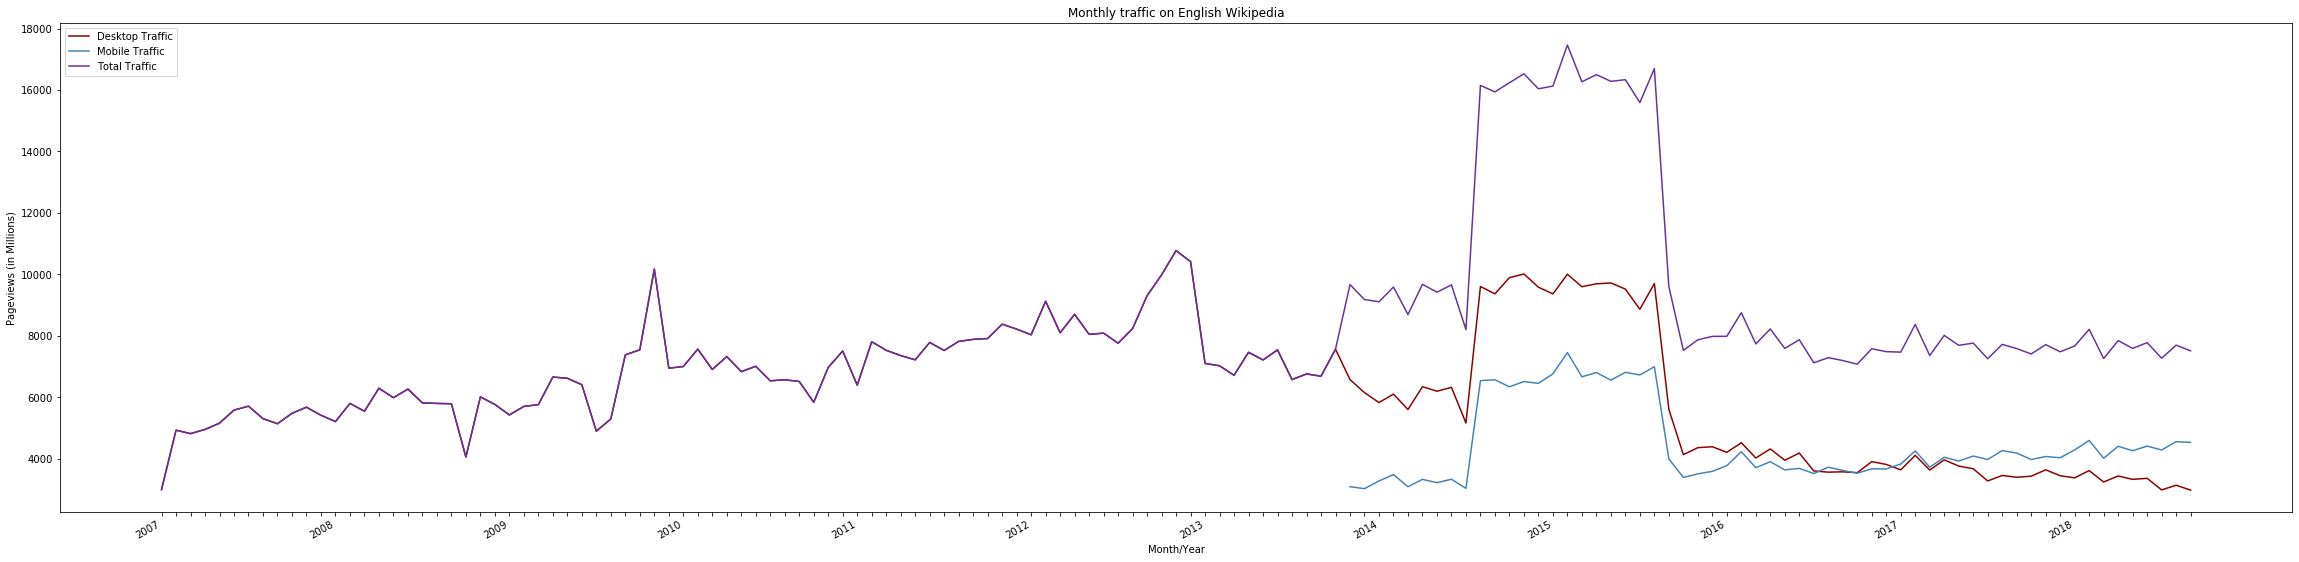

In [10]:
# ANALYSIS: PLOT THE DATA AS TIME SERIES

# make a month/year col to use as X-axis
merged_views_df['month_year'] = merged_views_df['month'] + " / " + merged_views_df['year']

# make totals cols for desktop and mobile (nans must be 0 to sum cols, but we do not want to plot 0s)
merged_views_df.replace(np.nan, 0, inplace = True)
merged_views_df['desktop_traffic'] = merged_views_df['pagecount_desktop_views'] + merged_views_df['pageview_desktop_views']
merged_views_df['mobile_traffic'] = merged_views_df['pagecount_mobile_views'] + merged_views_df['pageview_mobile_views']
merged_views_df['all_traffic'] = merged_views_df['pagecount_all_views'] + merged_views_df['pageview_all_views']
merged_views_df.replace(0, np.nan, inplace = True)

# create the plot with three individual lines
fig, ax = plt.subplots(figsize = (40,10))
plt.plot(merged_views_df['month_year'], merged_views_df['desktop_traffic']/1000000, label = 'Desktop Traffic', color = 'darkred')
plt.plot(merged_views_df['month_year'], merged_views_df['mobile_traffic']/1000000, label='Mobile Traffic', color = 'steelblue')
plt.plot(merged_views_df['month_year'], merged_views_df['all_traffic']/1000000, label='Total Traffic', color = 'rebeccapurple')
plt.legend(loc = 'upper left')
plt.title("Monthly traffic on English Wikipedia")
ax.set_ylabel("Pageviews (in Millions)")
ax.set_xlabel("Month/Year")

# use matplotlib to label every 12th tick, starting with the first; labels will be annual)
def x_tick_labels(tick_val, pos):
    if (tick_val % 12 == 0):
        return merged_views_df["year"][tick_val]
    else: return ""

ax.xaxis.set_major_formatter(tick.FuncFormatter(x_tick_labels))
fig.autofmt_xdate()

# display the plot
plt.draw()

# save the plot
plt.savefig("en-wikipedia_traffic_200712-201808.png")